In [1]:
#this version of the program is using presets for the cyclic peptide library

In [2]:
#This program is used for unpaired read illumina sequencing fastq files.  The goal here is to take in your
#sequencing file, and to cut out reads that match your defined template.  In this case of a synthetic 
#peptide library we know the exact sequences that should be constant before and after our randomized positions.
#Using the user specified sequences we cut out those sequences and then translate them to AA sequences. 
# please note that the user specified sequences need to be in-frame (all of our mutants are in frame)
from datetime import datetime
from Bio.Seq import Seq
from Bio import SeqIO
import modin.pandas as pd #multithreading version of pandas
from distributed import Client
import os
client = Client()

# Directory containing the .fa files
Output_directory = "Output_Files"

# Create the directory folder if it doesn't exist
if not os.path.exists(Output_directory):
    os.makedirs(Output_directory)
# Directory containing the .fa files
Scatterplot_directory = "Scatterplots"

# Create the directory folder if it doesn't exist
if not os.path.exists(Scatterplot_directory):
    os.makedirs(Scatterplot_directory)

def reverse_complement(seq):
    """Return the reverse complement of a DNA sequence"""
    return str(Seq(seq).reverse_complement())


# User-defined sequences in 5' to 3' direction - you can also add other startX and stopXs to the lists
seqs_5to3 = {
    "start1": "GAAGGGGTACAATTAGAT",
    "stop1": "GAATGGCATGAAGGT",
}

# User-defined sequences in 3' to 5' direction - this is the same sequence you put above, just in reverse
seqs_3to5 = {
    "start3": "ACCTTCATGCCATTC", #this should be the reverse complement of stop 1
    "stop3": "ATCTAATTGTACCCCTTC",#this should be the reverse complement of start1
}

# Convert 3' to 5' sequences to 5' to 3'
seqs_5to3.update(
    {f"{key}_rc": reverse_complement(val) for key, val in seqs_3to5.items()}
)

# Initialize an empty list to store results
results = []

# Iterate over each record in the FASTQ file
for record in SeqIO.parse("Illumina_test_peptide.fastq", "fastq"):
    # Extract the DNA sequence from the record
    seq = str(record.seq)

    # Iterate over the user-defined sequences
    for seq_key, seq_val in seqs_5to3.items():
        # Find the start and end indices of the sequence of interest
        start_index = seq.find(seq_val)
        end_index = seq.find(seqs_5to3[f"{seq_key.replace('start', 'stop')}"], start_index + len(seq_val))

        # Check if the sequence of interest was found
        if start_index != -1 and end_index != -1:
            # Extract the DNA sequence between the start and stop sequences
            dna_seq = seq[start_index + len(seq_val): end_index]

            # Reverse complement the DNA sequence if the user-defined sequence was in the 3' to 5' direction
            if seq_key.endswith("_rc"):
                dna_seq = reverse_complement(dna_seq)

            # Translate the DNA sequence to amino acids
            aa_seq = Seq(dna_seq).translate()

            # Add the result to the list of results
            results.append({"Sequence": aa_seq, "KD": "1"})

# Convert the results to a pandas DataFrame and write to an Excel file

df = pd.DataFrame(results)
df.to_excel("Output_Files/output-peptide-clusters.xlsx", index=False)

To request implementation, send an email to feature_requests@modin.org.


                                Sequence  KD
0  KREAEAGPHMADCAWHLGELVWCTGGGLNDIFEAQKI   1
1  KREAEAGPHMADCAWHLGGLVWCTGGGLNDIFEAQKI   1
2  KREAEAGPHMADCAWHLGELVWCTGGGLNDIFEAQKI   1
3  KREAEAGPHMADCARQLGQSVSCTGGGLNDIFEAQKI   1
Number of clusters found: 1


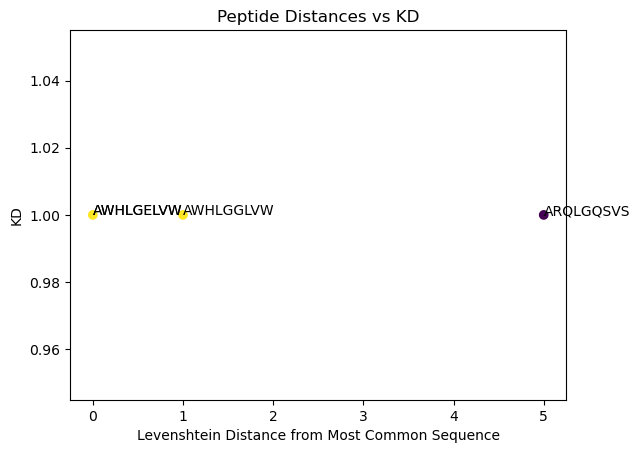

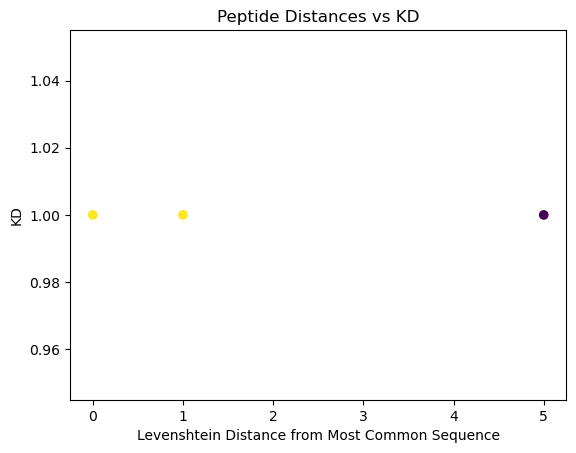

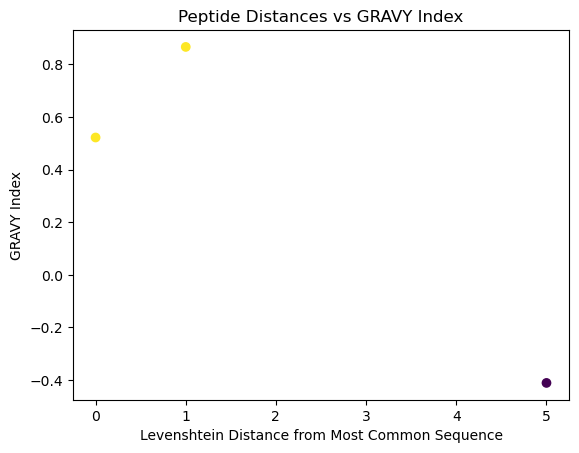

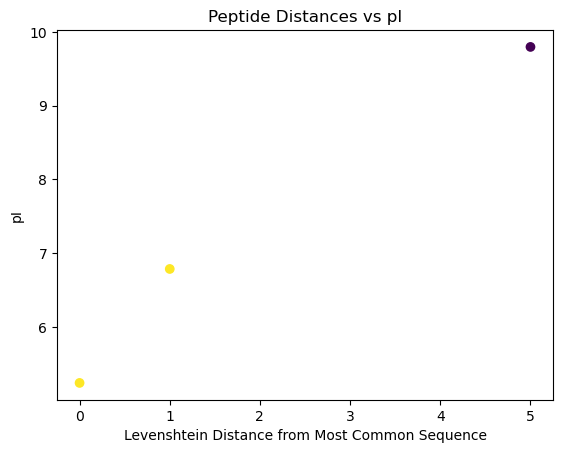

In [3]:
#this works, just has the future warning
import matplotlib.pyplot as plt
import pandas as pd
import Levenshtein as lev
from matplotlib.pyplot import figure
from sklearn.cluster import DBSCAN
from Levenshtein import distance
import numpy as np

# Define the framework sequences
frameworks = {
    'Framework1': 'KREAEAGPHMADC',
    'Framework2': 'CTGGGLNDIFEAQKI',
}

# Define the CDR loop positions relative to the framework sequences
cdr_positions = {
    'CDR1': ['Framework1', 'Framework2']
    #'CDR2': ['Framework2', 'Framework3'], #we don't need these because we only have one "framework"
    #'CDR3': ['Framework3', 'Framework4']
}

# Load the data from the Excel file
df = pd.read_excel('Output_Files/output-peptide-clusters.xlsx')
print(df)
# Extract the CDR loop sequences
cdr_seqs = {}
for cdr, positions in cdr_positions.items():
    start, end = positions
    cdr_seqs[cdr] = [seq[seq.find(frameworks[start])+len(frameworks[start]):seq.find(frameworks[end])] for seq in df['Sequence']]

# Calculate the frequency percentage of each CDR sequence as a percentage
cdr_freqs = {}
for cdr in cdr_seqs:
    cdr_count = len(cdr_seqs[cdr])
    cdr_freqs[cdr] = [cdr_seqs[cdr].count(seq)/cdr_count*100 for seq in cdr_seqs[cdr]]


# Find the most common CDR sequence for each loop
cdr_consensus_seqs = {}
for cdr in cdr_seqs:
    max_freq_idx = cdr_freqs[cdr].index(max(cdr_freqs[cdr]))
    cdr_consensus_seqs[cdr] = cdr_seqs[cdr][max_freq_idx]

# Calculate the Levenshtein distance between each CDR sequence and the consensus sequence
cdr_distances = {}
for cdr in cdr_seqs:
    cdr_distances[cdr] = [lev.distance(seq, cdr_consensus_seqs[cdr]) for seq in cdr_seqs[cdr]]

# Create a new dataframe with the results, removing duplicate sequences
cdr_df = pd.DataFrame()
for i, (sequence, kd) in df[['Sequence', 'KD']].iterrows():
    cdr_df = pd.concat([cdr_df, pd.DataFrame({'Sequence': sequence,
                                           'KD': kd,
                                           'CDR1 Seq': cdr_seqs['CDR1'][i],
                                           'CDR1 Freq': cdr_freqs['CDR1'][i],
                                           'CDR1 Distance': cdr_distances['CDR1'][i]}, index=[i])],
                    ignore_index=True)

cdr_df = cdr_df.drop_duplicates(subset=['Sequence', 'CDR1 Seq'])
cdr_df[['CDR1 Freq']] = cdr_df[['CDR1 Freq']].apply(lambda x: round(x, 2))


# Define a function to compute the pairwise distance matrix between all sequences
def pairwise_distance_matrix(sequences):
    n = len(sequences)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            dist_matrix[i, j] = distance(sequences[i], sequences[j])
            dist_matrix[j, i] = dist_matrix[i, j]
    return dist_matrix

# Compute the pairwise distance matrix
dist_matrix = pairwise_distance_matrix(cdr_df['CDR1 Seq'].values)

# Run DBSCAN on the distance matrix
dbscan = DBSCAN(metric='precomputed', eps=1.5, min_samples=2)
dbscan.fit(dist_matrix)

# Extract the cluster labels
cluster_labels = dbscan.labels_

# Print the number of clusters found
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print('Number of clusters found:', n_clusters)

# Add the cluster labels to the dataframe
cdr_df['Cluster'] = cluster_labels

from Bio.SeqUtils.ProtParam import ProteinAnalysis
import pandas as pd

# Define a function to calculate GRAVY and pI
def calculate_gravy_and_pi(seq):
    # Create a ProteinAnalysis object for the amino acid sequence
    protein = ProteinAnalysis(seq)
    
    # Calculate GRAVY
    gravy = protein.gravy()
    
    # Calculate pI
    pi = protein.isoelectric_point()
    
    return gravy, pi

# Apply the function to the 'CDR1 Seq' column and store the results in new columns
cdr_df[['GRAVY_Index', 'pI']] = pd.DataFrame(cdr_df['CDR1 Seq'].apply(calculate_gravy_and_pi).tolist(), index=cdr_df.index)
cdr_df = cdr_df.reset_index(drop=True)
# Save the results to a new Excel file
cdr_df.to_excel('Output_Files/peptide_distances.xlsx', index=False)

# Create scatterplots for each CDR loop

for cdr in cdr_distances:
    plt.scatter(cdr_df['CDR1 Distance'], cdr_df['KD'], c=cluster_labels)
    plt.xlabel('Levenshtein Distance from Most Common Sequence')
    plt.ylabel('KD')
    plt.title("Peptide Distances vs KD")
    for i, seq in enumerate(cdr_seqs[cdr]):
        plt.annotate(seq, (cdr_distances[cdr][i], df['KD'][i]))
    plt.savefig('Scatterplots/Scatter_with_sequences.png', dpi=300)
    plt.show()
    
for cdr in cdr_distances:
    plt.scatter(cdr_df['CDR1 Distance'], cdr_df['KD'], c=cluster_labels)
    plt.xlabel('Levenshtein Distance from Most Common Sequence')
    plt.ylabel('KD')
    plt.title("Peptide Distances vs KD")
    plt.savefig('Scatterplots/Scatter_only_KD_distance.png', dpi=300)
    plt.show()
for cdr in cdr_distances:
    plt.scatter(cdr_df['CDR1 Distance'], cdr_df['GRAVY_Index'], c=cluster_labels)
    plt.xlabel('Levenshtein Distance from Most Common Sequence')
    plt.ylabel('GRAVY Index')
    plt.title("Peptide Distances vs GRAVY Index")
    plt.savefig('Scatterplots/Scatter_only_GRAVY_distance.png', dpi=300)
    plt.show()
for cdr in cdr_distances:
    plt.scatter(cdr_df['CDR1 Distance'], cdr_df['pI'], c=cluster_labels)
    plt.xlabel('Levenshtein Distance from Most Common Sequence')
    plt.ylabel('pI')
    plt.title("Peptide Distances vs pI")
    plt.savefig('Scatterplots/Scatter_only_pI_distance.png', dpi=300)
    plt.show()

In [4]:
cdr_df


,Sequence,KD,CDR1 Seq,CDR1 Freq,CDR1 Distance,Cluster,GRAVY_Index,pI
0,KREAEAGPHMADCAWHLGELVWCTGGGLNDIFEAQKI,1,AWHLGELVW,50.0,0,0,0.522222,5.241828
1,KREAEAGPHMADCAWHLGGLVWCTGGGLNDIFEAQKI,1,AWHLGGLVW,25.0,1,0,0.866667,6.786087
2,KREAEAGPHMADCARQLGQSVSCTGGGLNDIFEAQKI,1,ARQLGQSVS,25.0,5,-1,-0.411111,9.795020


In [5]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from Bio import AlignIO
import pandas as pd

# Read the amino acid sequences from the CDR1 Seq column of the dataframe
sequences = [SeqRecord(Seq(seq), id=str(i+1)) for i, seq in enumerate(cdr_df['CDR1 Seq'])]

# Align the sequences
alignment = MultipleSeqAlignment(sequences)

# Write the aligned sequences to a file in FASTA format
with open('Clusters/cdr1_global_alignment.fa', 'w') as f:
    AlignIO.write(alignment, f, 'fasta')
print("Global alignment completed")

Global alignment completed


In [6]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment

# Read the sequences from the DataFrame
cdr_sequences = cdr_df['CDR1 Seq'].tolist()

# Group sequences by cluster
groups = cdr_df.groupby('Cluster')
for cluster, group in groups:
    # Create a list of SeqRecord objects
    seq_records = []
    for i, seq in enumerate(group['CDR1 Seq']):
        seq_record = SeqRecord(Seq(seq), id=f'seq{i+1}')
        seq_records.append(seq_record)
    
    # Align the sequences
    alignment = MultipleSeqAlignment(seq_records)
    
    # Write the aligned sequences to a file in FASTA format
    with open(f'Clusters/cdr1_alignment_{cluster}.fa', 'w') as f:
        SeqIO.write(alignment, f, 'fasta')
print("Cluster sequence alignment completed")

Cluster sequence alignment completed


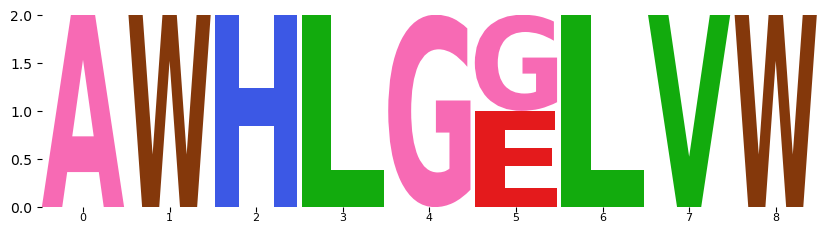

In [7]:
import logomaker
from Bio import AlignIO

# Read in the alignment file in FASTA format
alignment = AlignIO.read("Clusters/cdr1_alignment_0.fa", "fasta")

# Convert the alignment to a list of sequences
sequences = [str(record.seq) for record in alignment]

# Convert the sequences to a pandas dataframe
alignment_df = logomaker.alignment_to_matrix(sequences)

# Create the sequence logo
logo = logomaker.Logo(alignment_df, color_scheme='dmslogo_funcgroup')
# Customize the logo appearance
logo.style_spines(visible=False)
logo.ax.xaxis.set_tick_params(labelsize=8, which='major', pad=0)
logo.ax.xaxis.set_tick_params(labelsize=0, which='minor', pad=0)
logo.ax.xaxis.set_major_locator(plt.MultipleLocator(1))

# Save the figure as a PDF file
logo_fig = logo.fig
logo_fig.savefig('Clusters/Logos/peptide_logo.png', dpi=300)

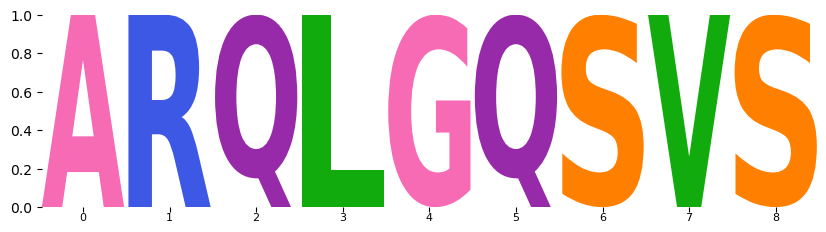

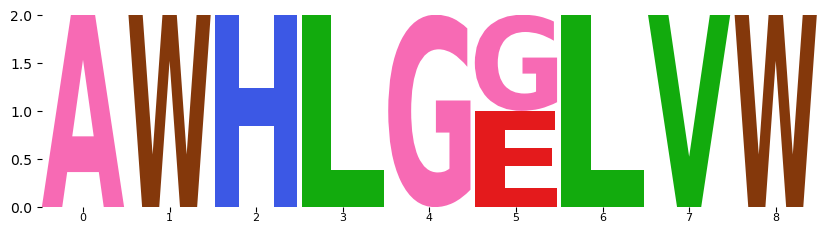

In [8]:
#for outputting every logo in the folder
import os
import logomaker
from Bio import AlignIO

# Directory containing the .fa files
directory = "Clusters"

# Create the directory folder if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Get a list of .fa files in the directory
fa_files = [file for file in os.listdir(directory) if file.startswith("cdr1_alignment_") and file.endswith(".fa")]

# Process each .fa file
for fa_file in fa_files:
    # Extract the varying part of the file name
    varying_part = fa_file[len("cdr1_alignment_"):-len(".fa")]

    # Read in the alignment file in FASTA format
    alignment = AlignIO.read(os.path.join(directory, fa_file), "fasta")

    # Convert the alignment to a list of sequences
    sequences = [str(record.seq) for record in alignment]

    # Convert the sequences to a pandas dataframe
    alignment_df = logomaker.alignment_to_matrix(sequences)

    # Create the sequence logo
    logo = logomaker.Logo(alignment_df, color_scheme='dmslogo_funcgroup')
    # Customize the logo appearance
    logo.style_spines(visible=False)
    logo.ax.xaxis.set_tick_params(labelsize=8, which='major', pad=0)
    logo.ax.xaxis.set_tick_params(labelsize=0, which='minor', pad=0)
    logo.ax.xaxis.set_major_locator(plt.MultipleLocator(1))

    # Create the "Logos" folder if it doesn't exist
    logos_folder = os.path.join(directory, "Logos")
    if not os.path.exists(logos_folder):
        os.makedirs(logos_folder)

    # Generate the output file name based on the varying part of the input file name
    output_file = os.path.join(logos_folder, f"peptide_logo_{varying_part}.png")

    # Save the figure as a PNG file
    logo_fig = logo.fig
    logo_fig.savefig(output_file, dpi=300)


In [9]:
print(cdr_df)

                                Sequence  KD   CDR1 Seq  CDR1 Freq  \
0  KREAEAGPHMADCAWHLGELVWCTGGGLNDIFEAQKI   1  AWHLGELVW       50.0   
1  KREAEAGPHMADCAWHLGGLVWCTGGGLNDIFEAQKI   1  AWHLGGLVW       25.0   
2  KREAEAGPHMADCARQLGQSVSCTGGGLNDIFEAQKI   1  ARQLGQSVS       25.0   

   CDR1 Distance  Cluster  GRAVY_Index        pI  
0              0        0     0.522222  5.241828  
1              1        0     0.866667  6.786087  
2              5       -1    -0.411111  9.795020  


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

df = cdr_df

parallel_df = pd.DataFrame({'CDR1 Seq': df['CDR1 Seq'], 'KD': df['KD']})

split_seqs = parallel_df['CDR1 Seq'].apply(list).apply(pd.Series)
split_seqs = split_seqs.fillna('Del')

# Define a dictionary to map amino acids to numeric codes
amino_acid_codes = {
    'A': 1,
    'C': 2,
    'D': 3,
    'E': 4,
    'F': 5,
    'G': 6,
    'H': 7,
    'I': 8,
    'K': 9,
    'L': 10,
    'M': 11,
    'N': 12,
    'P': 13,
    'Q': 14,
    'R': 15,
    'S': 16,
    'T': 17,
    'V': 18,
    'W': 19,
    'Y': 20,
    'Del': 21
}

# Convert amino acids to numeric codes
split_seqs = split_seqs.replace(amino_acid_codes)
print(split_seqs)



   0   1   2   3  4   5   6   7   8
0  1  19   7  10  6   4  10  18  19
1  1  19   7  10  6   6  10  18  19
2  1  15  14  10  6  14  16  18  16


In [11]:
import pandas as pd
import matplotlib.pyplot as plt

df = cdr_df

parallel_df = pd.DataFrame({'CDR1 Seq': df['CDR1 Seq'], 'KD': df['KD']})

split_seqs = parallel_df['CDR1 Seq'].apply(list).apply(pd.Series)
split_seqs = split_seqs.fillna('Del')

# Define a dictionary to map amino acids to numeric codes
amino_acid_codes = {
    'R': 1,
    'H': 2,
    'K': 3,
    'Del': 4,
    'A': 5,
    'V': 6,
    'I': 7,
    'L': 8,
    'M': 9,
    'F': 10,
    'Y': 11,
    'W': 12,
    'S': 13,
    'T': 14,
    'N': 15,
    'Q': 16,
    'C': 17,
    'G': 18,
    'P': 19,
    'E': 20,
    'D': 21
}

# Convert amino acids to numeric codes
split_seqs = split_seqs.replace(amino_acid_codes)

# Rename the columns in split_seqs to 'CDR1.X'
split_seqs.columns = [f'CDR1.{i+1}' for i in range(split_seqs.shape[1])]

split_seqs = split_seqs.assign(KD=cdr_df['KD'])
print("Splitting CDR Loop residues")
print(split_seqs)
MinKD= min(cdr_df['KD'])
MaxKD= max(cdr_df['KD'])
print("Minimum KD ")
print(MinKD)
print("Maximum KD ")
print(MaxKD)
split_seqs = split_seqs.assign(Cluster=cdr_df['Cluster'])
MaxClusters= max(cdr_df['Cluster'])
MinClusters= min(cdr_df['Cluster'])
print("Number of Clusters Found")
print(abs(MaxClusters-MinClusters)+1)

Splitting CDR Loop residues
   CDR1.1  CDR1.2  CDR1.3  CDR1.4  CDR1.5  CDR1.6  CDR1.7  CDR1.8  CDR1.9  KD
0       5      12       2       8      18      20       8       6      12   1
1       5      12       2       8      18      18       8       6      12   1
2       5       1      16       8      18      16      13       6      13   1
Minimum KD 
1
Maximum KD 
1
Number of Clusters Found
2


In [12]:
import pandas as pd
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)

amino_acids = ['R', 'H', 'K', 'DEL', 'A', 'V', 'I', 'L', 'M', 'F', 'Y', 'W', 'S', 'T', 'N', 'Q', 'C', 'G', 'P', 'E', 'D']

dimensions = []

for col in split_seqs.columns:  #this works with any number of CDR1 residues (aka both 9 and 11 length peptides)
    if col.startswith('CDR'):
        dimension = dict(range=[1, 21],
                         label=col,
                         values=split_seqs[col],
                         tickvals=list(range(1, 22)),
                         ticktext=amino_acids)
        dimensions.append(dimension)
    if col.startswith('KD'):
        KD_dimension = dict(range=[MinKD,MaxKD],
                        label=col,
                         values=split_seqs[col])
        dimensions.append(KD_dimension)
    if col.startswith('Cluster'):
        KD_dimension = dict(range=[MinClusters,MaxClusters],
                        label=col,
                         values=split_seqs[col])
        dimensions.append(KD_dimension)
fig = go.Figure(data=go.Parcoords(
    line=dict(color=split_seqs['CDR1.1'],
              colorscale='Jet',
              showscale=False,
              cmin=1,
              cmax=21),
    dimensions=dimensions
))

fig.update_layout(
    title="Hit Peptide Sequences",
    width=800,
    height=600
)

pyo.iplot(fig, filename='Output_Files/parallel_coordinates_plot.html')

In [13]:
cdr_df

,Sequence,KD,CDR1 Seq,CDR1 Freq,CDR1 Distance,Cluster,GRAVY_Index,pI
0,KREAEAGPHMADCAWHLGELVWCTGGGLNDIFEAQKI,1,AWHLGELVW,50.0,0,0,0.522222,5.241828
1,KREAEAGPHMADCAWHLGGLVWCTGGGLNDIFEAQKI,1,AWHLGGLVW,25.0,1,0,0.866667,6.786087
2,KREAEAGPHMADCARQLGQSVSCTGGGLNDIFEAQKI,1,ARQLGQSVS,25.0,5,-1,-0.411111,9.795020
